In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pycrm

sns.set(style='white')
%matplotlib inline

COHORT

In [86]:
df = pd.read_excel("/home/pfcor/Downloads/chapter-12-relay-foods.xlsx", sheet_name=1)
df.columns = ["order_id", "order_date", "customer_id", "order_value", "sku", "pup_id", "pickup_date"]

In [87]:
df.head()

,order_id,order_date,customer_id,order_value,sku,pup_id,pickup_date
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [88]:
df = df.set_index('customer_id')
df['cohort_group'] = df.groupby(level=0)['order_date'].min().apply(lambda x: x.strftime('%Y-%m'))
df = df.reset_index()
df.head()

,customer_id,order_id,order_date,order_value,sku,pup_id,pickup_date,cohort_group
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-01


In [89]:
df["order_period"] = df["order_date"].dt.strftime("%Y-%m")

In [90]:
grouped = df.groupby(['cohort_group', "order_period"])

# count the unique users, orders, and total revenue per Group + Period
cohorts = (
    grouped.agg(
        {
            'customer_id': pd.Series.nunique,
            'order_id': pd.Series.nunique,
            'order_value': np.sum
        }
    )
).rename(
    columns={
        'customer_id': 'total_users',
        'order_id': 'total_orders'
    }
)

cohorts.head()

total_users  total_orders  order_value
cohort_group order_period                                        
2009-01      2009-01                22            30     1850.255
             2009-02                 8            25     1351.065
             2009-03                10            26     1357.360
             2009-04                 9            28     1604.500
             2009-05                10            26     1575.625

In [91]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['cohort_period'] = np.arange(df.shape[0]) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_users  total_orders  order_value  \
cohort_group order_period                                           
2009-01      2009-01                22            30     1850.255   
             2009-02                 8            25     1351.065   
             2009-03                10            26     1357.360   
             2009-04                 9            28     1604.500   
             2009-05                10            26     1575.625   

                           cohort_period  
cohort_group order_period                 
2009-01      2009-01                   1  
             2009-02                   2  
             2009-03                   3  
             2009-04                   4  
             2009-05                   5

In [92]:
# reindex the DataFrame
cohorts = cohorts.reset_index()
cohorts = cohorts.set_index(['cohort_group', 'cohort_period'])
cohorts.head()

order_period  total_users  total_orders  \
cohort_group cohort_period                                           
2009-01      1                  2009-01           22            30   
             2                  2009-02            8            25   
             3                  2009-03           10            26   
             4                  2009-04            9            28   
             5                  2009-05           10            26   

                            order_value  
cohort_group cohort_period               
2009-01      1                 1850.255  
             2                 1351.065  
             3                 1357.360  
             4                 1604.500  
             5                 1575.625

In [93]:
# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort_group
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: total_users, dtype: int64

In [94]:
cohorts['total_users'].unstack(0).head()

cohort_group,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
cohort_period,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN


In [95]:
user_retention = cohorts['total_users'].unstack(0) / (cohort_group_size)
user_retention.head(10)

cohort_group,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
cohort_period,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


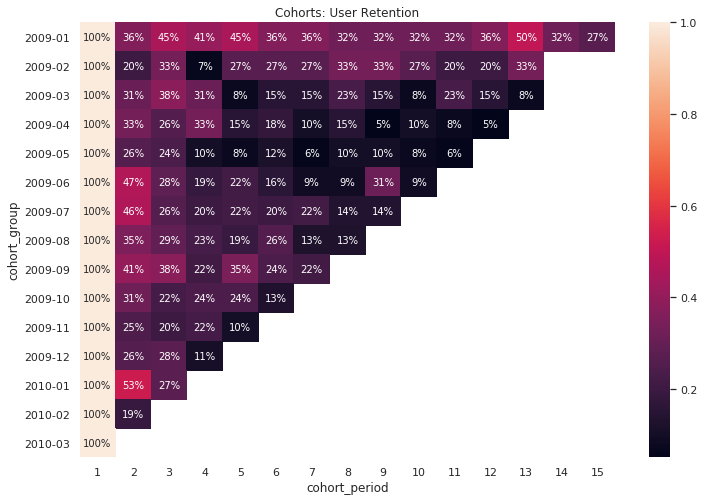

In [96]:
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

CDNOW

In [14]:
df_cdnow = pycrm.datasets.load_cdnow_dataset()

In [15]:
df_cdnow.head()

,customer_id,order_date,n_items,order_value
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [10]:
df_cdnow_agg = pycrm.aggregate_transactions_time(df_cdnow,  aggregation="revenue", freq="D", full_intervals_only=False)

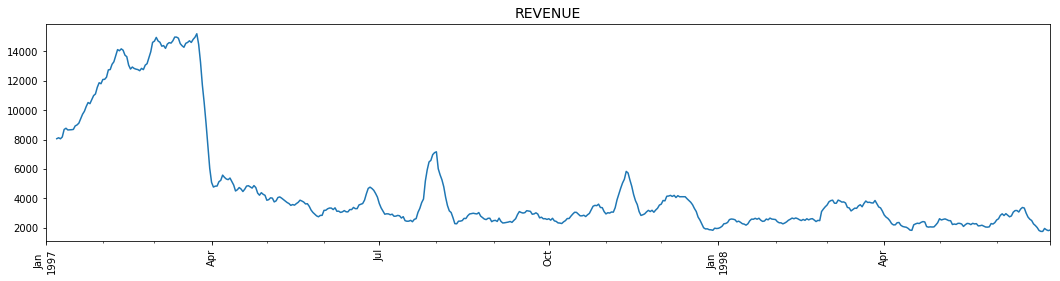

In [12]:
pycrm.plotting.plot_transaction_timeseries(df_cdnow_agg, rolling_window=7)

In [6]:
df_cdnow_agg

,revenue
order_date,
1997-12-31,2024161.26
1998-12-31,476154.37


In [17]:
lang = 'Python'
adj = 'Very Good'
width = "<20"
f'{lang:{width}}: {adj:{width}}'
# Out[582]: '              Python:            Very Good'

'Python              : Very Good           '

In [46]:
v = 251246134 

f_mlt = 1/1e6
f_fmt = f".0f"
f_pref = "R$ "
f_suff = "M"

In [47]:
f"{pref}{v:{fmt}}{suff}"

'R$ 251M'

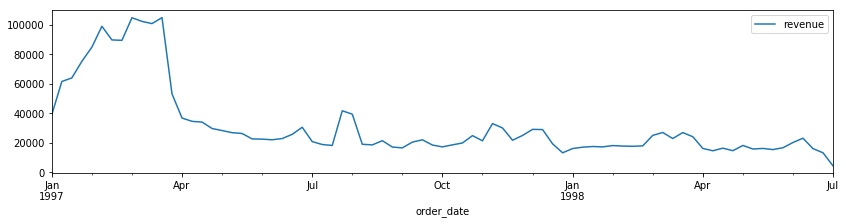

In [18]:
df_cdnow_agg.plot(kind="line", figsize=(14,3))

In [87]:
def plot_transaction_timeseries(transaction_series, reg=False, **kwargs):
       
    # input validation 
    if isinstance(transaction_series, pd.DataFrame):
        assert transaction_series.shape[1] == 1, "only single column pandas.DataFrame supported"
        transaction_series = transaction_series.copy()
    elif isinstance(transaction_series, pd.Series):
        transaction_series = transaction_series.copy().to_frame()
    else:
        raise TypeError(f"invalid transaction_series input: {type(transaction_series)} - pandas.Series or single column pandas.DataFrame supported only")
    assert isinstance(transaction_series.index, pd.DatetimeIndex), "index not of pandas.DatetimeIndex type"
    
    rolling_window = kwargs.get("rolling_window", 1)
    assert rolling_window > 0, "window must be positive"
    assert isinstance(rolling_window, int), "window must be an integer"  
    
    # creating figure    
    ax = kwargs.get("ax")
    if not ax:
        fig, ax = plt.subplots(figsize=kwargs.get("figsize", (18,4)))
        
    # plotting series
    (transaction_series.iloc[:, 0]).rolling(rolling_window).mean().plot(ax=ax, label=kwargs.get("label"))
    
    # perform (and plot) single linear regression on series
    # WARNING: simplistic treatment of timeseries data - should not be used in serious analysis
    if reg:
        f = np.poly1d(np.polyfit(range(transaction_series.shape[0]), (transaction_series.iloc[:, 0]).values, 1)) 
        transaction_series["fitted_line"] = f(np.arange(transaction_series.shape[0]))
        transaction_series["fitted_line"].plot(ax=ax, lw=2, ls='--', alpha=.5, label="Eq_normal: " + f"{f}".strip())
    
    # plot details shortcut
    if kwargs.get("legend", False):
        ax.legend()
    ax.set_title(kwargs.get("title", f"{transaction_series.columns[0].upper()}"), size=kwargs.get("title_size", 14))
    ax.set_xlabel(kwargs.get("xlabel", ""))
    ax.set_ylabel(kwargs.get("ylabel", ""))
    if "xlim" in kwargs:
        ax.set_xlim(kwargs.get("xlim"))
    if "ylim" in kwargs:
        ax.set_ylim(kwargs.get("ylim"))

    return ax
    

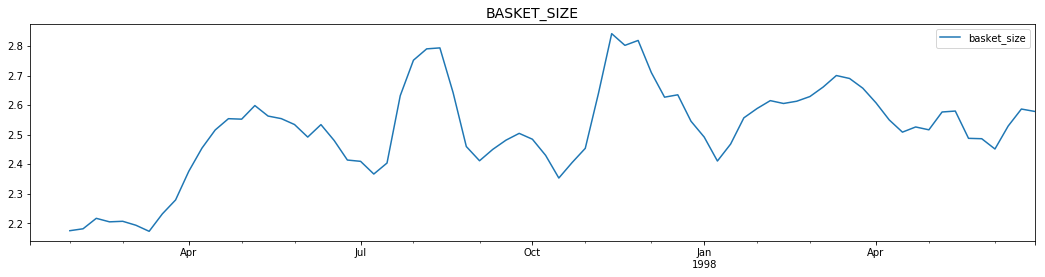

In [90]:
plot_transaction_timeseries(df_cdnow_agg, legend=True, rolling_window=4)

In [22]:
isinstance(df_cdnow_agg, pd.DataFrame)

True

In [30]:
isinstance(df_cdnow_agg["basket_size"].index, pd.DatetimeIndex)

True

In [32]:
df_cdnow_agg["basket_size"].to_frame()

,basket_size
order_date,
1997-01-12,2.182121
1997-01-19,2.113602
1997-01-26,2.190138
1997-02-02,2.213147
1997-02-09,2.208033
1997-02-16,2.255172
1997-02-23,2.142545
1997-03-02,2.220617
1997-03-09,2.154365


In [26]:
type(df_cdnow_agg.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
def plot_transactions_ts(transactional_df, frequency="M", aggregation="n_purchases", reg=False, black_friday_dates=None, plot_black_friday=False, plot_normal_only=False, **kwargs):
    """
    plota a evolucao das compras no tempo
    black_friday_dates:: list of datetime.date
    """

    if "black_friday" in transactional_df.columns:
        if frequency != 'Y':
            df = df.join(grouper["black_friday"].max())
            
    
    if plot_black_friday or plot_normal_only:
        assert "black_friday" in df.columns, "No Black Friday Information Available"
        
        # n_purchases on normal days
        df[f"{aggregation}_normal"] = df[aggregation]
        df.loc[df["black_friday"] == 1, f"{aggregation}_normal"] = np.nan
        df[f"{aggregation}_normal"] = df[f"{aggregation}_normal"].interpolate(method="linear")
        
        # por plotting reasons, considering "neighbor" rows as black_friday == 1
        try:
            bf_idx = [(i-1, i, i+1) for i in df.reset_index()[df.reset_index()["black_friday"] == 1].index]
            bf_idx = list(set(list(sum(bf_idx, ()))))
            df.iloc[bf_idx, (df.columns == "black_friday").argmax()] = 1
        except IndexError:
            pass
        
        # n_purchases on black friday days
        df[f"{aggregation}_bf"] = df[aggregation]
        df.loc[df["black_friday"] != 1, f"{aggregation}_bf"] = np.nan        
    
    # plot!
    ax = kwargs.get("ax")
    if not ax:
        fig, ax = plt.subplots(figsize=kwargs.get("figsize", (18,4)))

    if plot_black_friday:
        (df[f'{aggregation}_normal']).rolling(kwargs.get("rolling_window", 1)).mean().plot(ax=ax, label=kwargs.get("label_normal", "Normal"))
        (df[f'{aggregation}_bf']).rolling(kwargs.get("rolling_window", 1)).mean().plot(ax=ax, label=kwargs.get("label_bf", "Black Friday"))
        
        # simple linear regression - WARNING: simplistic treatment of timeseries data
        if reg:
            f = np.poly1d(np.polyfit(range(df.shape[0]), (df[f'{aggregation}_normal']).values, 1)) 
            df["fitted_line"] = f(np.arange(df.shape[0]))
            df["fitted_line"].plot(ax=ax, lw=2, ls='--', alpha=.5, label="Eq_normal: " + f"{f}".strip())
        
    elif plot_normal_only:
        (df[f'{aggregation}_normal']).rolling(kwargs.get("rolling_window", 1)).mean().plot(ax=ax, label=kwargs.get("label_normal", "Normal"))
        
        # simple linear regression - WARNING: simplistic treatment of timeseries data
        if reg:
            f = np.poly1d(np.polyfit(range(df.shape[0]), (df[f'{aggregation}_normal']).values, 1)) 
            df["fitted_line"] = f(np.arange(df.shape[0]))
            df["fitted_line"].plot(ax=ax, lw=2, ls='--', alpha=.5, label="Eq_normal: " + f"{f}".strip())
        
    else:
        (df[aggregation]).rolling(kwargs.get("rolling_window", 1)).mean().plot(ax=ax, label=kwargs.get("label"))
        
        # simple linear regression - WARNING: simplistic treatment of timeseries data
        if reg:
            f = np.poly1d(np.polyfit(range(df.shape[0]), (df[aggregation]).values, 1)) 
            df["fitted_line"] = f(np.arange(df.shape[0]))
            df["fitted_line"].plot(ax=ax, lw=2, ls='--', alpha=.5, label="Eq_normal: " + f"{f}".strip())

    if kwargs.get("legend", False):
        ax.legend()

    ax.set_title(kwargs.get("title", f"{aggregation.upper()} - {frequency}"), size=kwargs.get("title_size", 14))
    
    ax.set_xlabel(kwargs.get("xlabel",""))

    return ax
